In [5]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
if 'cvxopt' not in installedPackages :
    !pip install cvxopt==1.2.5

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

import warnings
warnings.filterwarnings('ignore')

In [6]:
def download_stocks(tickers,start='2014-01-01',end='2019-01-01'):
    return yf.download(tickers, start = start, end = end)

In [7]:
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)
SP_tickers = SP_stocks[0]['Symbol'].to_list()

SP_data = download_stocks(SP_tickers,start='2010-01-01')['Adj Close'].dropna(axis=1)
SP_data.index = pd.to_datetime(SP_data.index)

total_time = SP_data.shape[0]
train_end = int(total_time*.6)
val_end = train_end + int(total_time*.2)

df = {}

df['train'] = SP_data[:train_end]
df['valid'] = SP_data[train_end:val_end]
df['test'] = SP_data[val_end:]

df_ret = {}
for key in df:
    df_ret[key] = df[key].pct_change().dropna()

[*********************100%***********************]  503 of 503 completed

11 Failed downloads:
- FOX: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- DOW: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- BF.B: No data found for this date range, symbol may be delisted
- CARR: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- OTIS: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- OGN: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- FOXA: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- CTVA: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- BRK.B: No timezone found, symbol may be delisted
- GEHC: Data doesn't exist for startDate = 1262322000, endDate = 1546318800
- CEG: Data doesn't exist for startDate = 1262322000, endDate = 1546318800


In [12]:
SP_data.isna().sum().sum()

0

In [14]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [17]:
dist = {}
link = {}

for key in df_ret:
    dist[key] = correlDist(df_ret[key].corr())
    link[key] = linkage(dist[key],'ward')

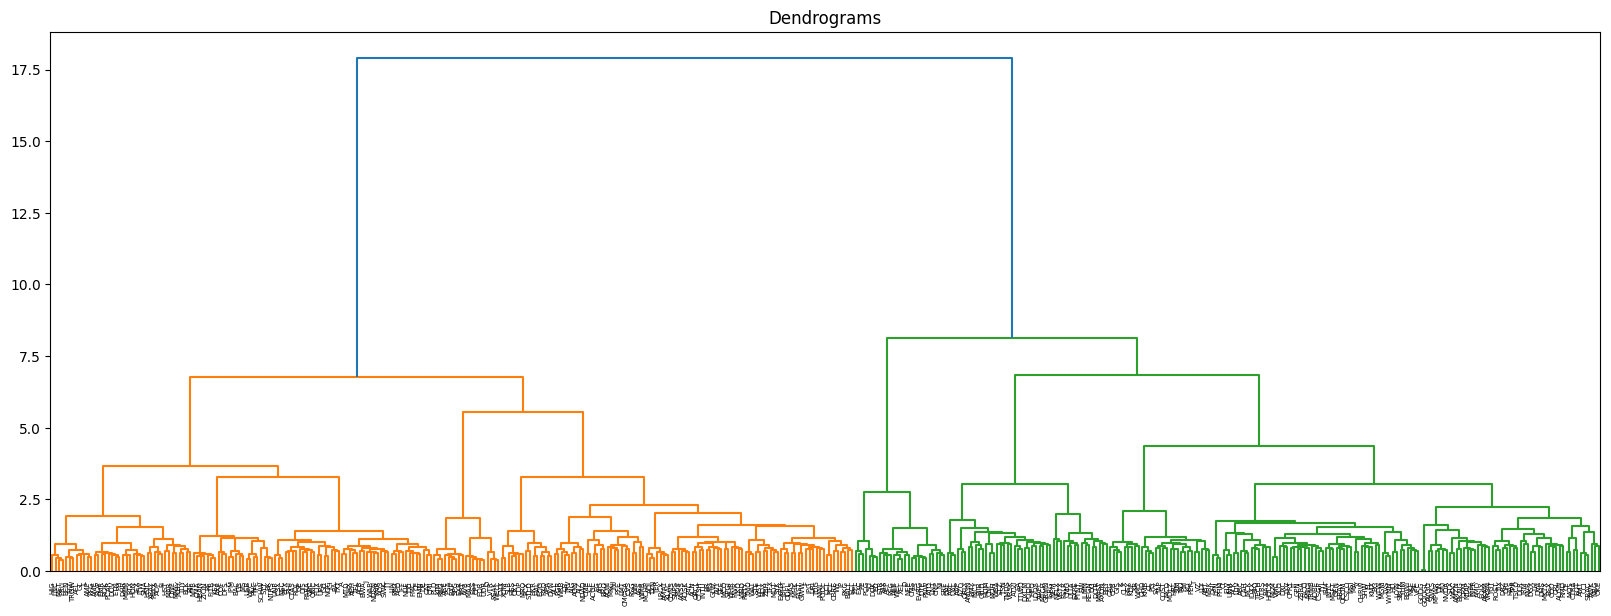

In [18]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")
dendrogram(link['train'],labels = df['train'].columns)
plt.show()

In [19]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

In [20]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [21]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [28]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, hrp,ivp], index=['MVP', 'HRP','IVP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [29]:
portfolios={}

for key in df_ret:
    portfolios[key] = get_all_portfolios(df_ret[key])

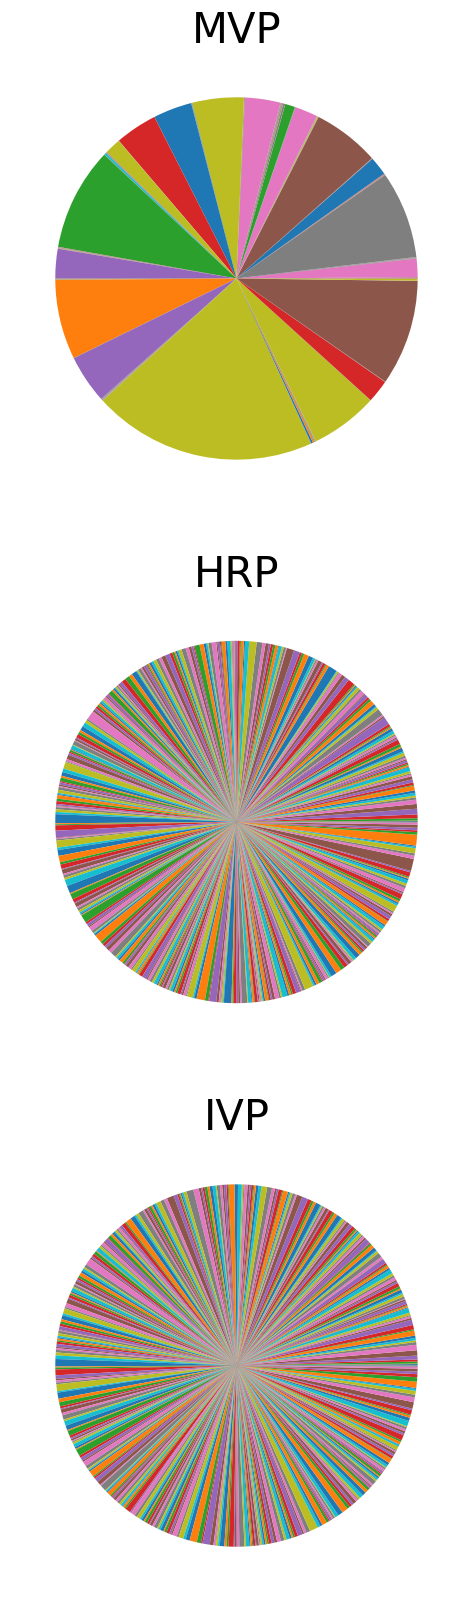

In [37]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(30,20))
ax1.pie(portfolios['train'].iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios['train'].iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)
ax3.pie(portfolios['train'].iloc[:,2]);
ax3.set_title('IVP',fontsize = 30)
plt.show()
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [39]:
df_ret.keys()

dict_keys(['train', 'valid', 'test'])

In [41]:
Results = {}

for key in df_ret:
    Results[key] = pd.DataFrame(np.dot(df_ret[key],np.array(portfolios['train'])), \
                             columns=['MVP', 'HRP','IVP'], index = df_ret[key].index)

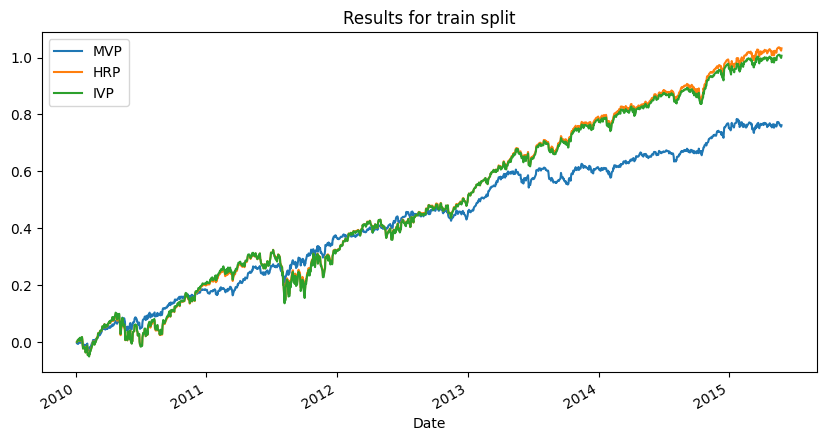

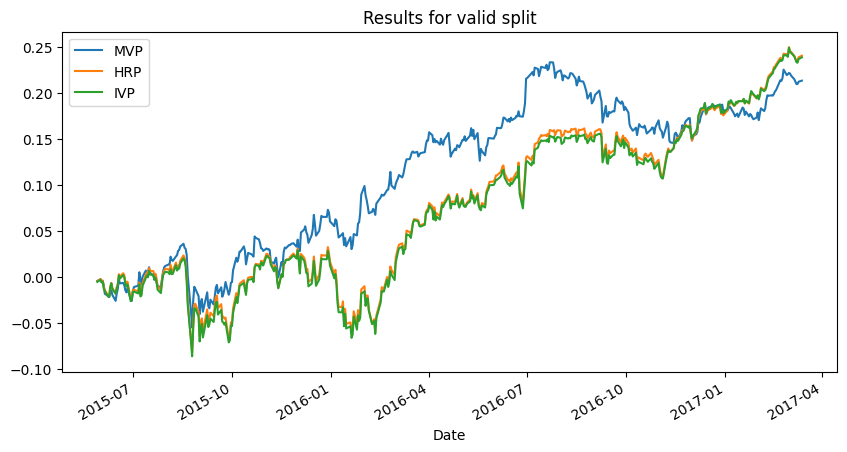

In [45]:
for key in ['train','valid']:
    Results[key].cumsum().plot(figsize = (10,5), title = f'Results for {key} split')

In [50]:
#In_sample Results
stddev_train = Results['train'].std() * np.sqrt(252)
sharp_ratio_train = (Results['train'].mean()*np.sqrt(252))/(Results['train']).std()
summary_train = pd.DataFrame(dict(stdev=stddev_train, sharp_ratio = sharp_ratio_train))
summary_train

,stdev,sharp_ratio
MVP,0.096677,1.464194
HRP,0.143309,1.338054
IVP,0.147786,1.264967


In [51]:
#In_sample Results
stddev_valid = Results['valid'].std() * np.sqrt(252)
sharp_ratio_valid = (Results['valid'].mean()*np.sqrt(252))/(Results['valid']).std()
summary_valid = pd.DataFrame(dict(stdev=stddev_valid, sharp_ratio = sharp_ratio_valid))
summary_valid

,stdev,sharp_ratio
MVP,0.114463,1.039717
HRP,0.129141,1.038857
IVP,0.129756,1.026209


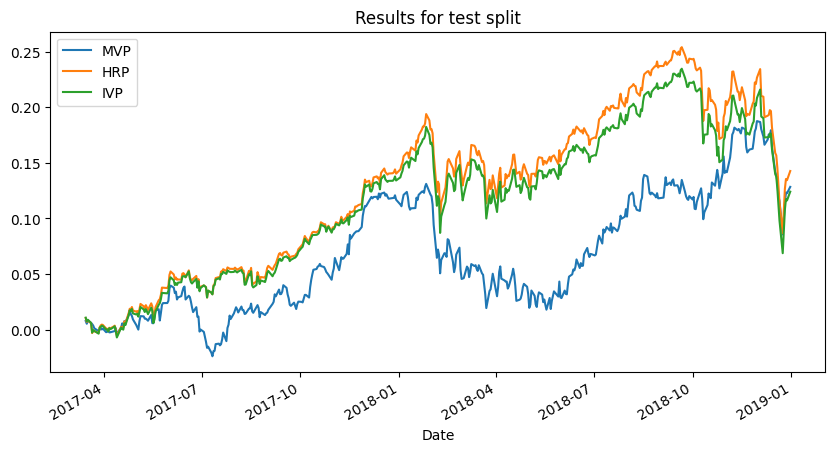

In [48]:
for key in ['test']:
    Results[key].cumsum().plot(figsize = (10,5), title = f'Results for {key} split')

In [53]:
#In_sample Results
stddev_test = Results['test'].std() * np.sqrt(252)
sharp_ratio_test = (Results['test'].mean()*np.sqrt(252))/(Results['test']).std()
summary_test = pd.DataFrame(dict(stdev=stddev_test, sharp_ratio = sharp_ratio_test))
summary_test

,stdev,sharp_ratio
MVP,0.105244,0.678513
HRP,0.111819,0.709718
IVP,0.110497,0.624698
